In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
#loading the csv data to a Pandas Dataframe
df = pd.read_csv('/content/Water_Quality_dataset.csv')

In [ ]:
#printing first 5 rows of the dataframe
df.head()

,Well ID,S.No,STATE,DISTRICT,BLOCK,LOCATION,LATITUDE,LONGITUDE,Year,pH,...,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,W113126092431802,1,A&N Islands,South Andaman,PORT BLAIR,Kodiaghat,11.545,92.74583,2021,7.74,...,25.0,1.0,1.0,175.0,34.0,22.0,10.0,0.0,0.84,206.0
1,W113616092411001,2,A&N Islands,South Andaman,PORT BLAIR,Sippighat,11.6025,92.73,2021,7.53,...,82.0,5.0,1.0,250.0,52.0,29.0,51.0,1.0,0.28,381.0
2,W113640092443301,3,A&N Islands,South Andaman,PORT BLAIR,Brichganj,11.62083,92.73028,2021,7.50,...,35.0,1.0,0.0,125.0,4.0,28.0,10.0,1.0,0.46,151.0
3,W114421092422801,4,A&N Islands,South Andaman,FERRARGUNJ,Wimberleyganj,11.7325,92.70861,2021,7.60,...,39.0,2.0,0.0,135.0,26.0,17.0,15.0,2.0,0.37,198.0
4,W113955092391801,5,A&N Islands,South Andaman,FERRARGUNJ,Ograbraj,11.66361,92.65806,2021,7.82,...,560.0,56.0,5.0,465.0,56.0,79.0,336.0,18.0,0.95,1424.0


In [ ]:
# Checking size of the dataset
df.shape

(5375, 23)

In [ ]:
# Checking for datatypes of the dataset
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE      object
LONGITUDE     object
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

# Converting object data type to numeric

In [ ]:
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 6
    for index in range(6, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

Well ID       object
S.No           int64
STATE         object
DISTRICT      object
BLOCK         object
LOCATION      object
LATITUDE     float64
LONGITUDE    float64
Year           int64
pH           float64
EC           float64
CO3          float64
HCO3         float64
Cl           float64
SO4          float64
NO3          float64
TH           float64
Ca           float64
Mg           float64
Na           float64
K            float64
F            float64
TDS          float64
dtype: object

In [ ]:
df.isnull().sum()

Well ID         0
S.No            0
STATE           0
DISTRICT        0
BLOCK          71
LOCATION        0
LATITUDE      811
LONGITUDE     810
Year            0
pH              0
EC              0
CO3             0
HCO3            0
Cl              0
SO4             1
NO3             0
TH              0
Ca              0
Mg              0
Na              0
K               1
F               0
TDS          2159
dtype: int64

# Handling null values

In [ ]:
df['BLOCK'].fillna("not specified",inplace = True)
df['LATITUDE'].fillna(method='bfill', inplace=True)
df['LONGITUDE'].fillna(method='bfill', inplace=True)
# df['SO4'].fillna(method='bfill', inplace=True)
# df['K'].fillna(method='bfill', inplace=True)
df['SO4'].fillna(df.SO4.mean(), inplace=True)
df['K'].fillna(df.K.mean(), inplace=True)
df['TDS'].fillna(df.TDS.mean(), inplace=True)

In [ ]:
df.isnull().sum()

Well ID      0
S.No         0
STATE        0
DISTRICT     0
BLOCK        0
LOCATION     0
LATITUDE     0
LONGITUDE    0
Year         0
pH           0
EC           0
CO3          0
HCO3         0
Cl           0
SO4          0
NO3          0
TH           0
Ca           0
Mg           0
Na           0
K            0
F            0
TDS          0
dtype: int64

# Water Quality Index (WQI) Calculation

In [ ]:
# Define Weight for each parameter
weights = {
    'pH': 0.10,    # Weight assigned to pH
    'EC': 0.12,    # Weight assigned to Electrical Conductivity
    'Cl': 0.08,    # Weight assigned to Chloride
    'TH': 0.10,    # Weight assigned to Total Hardness
    'Ca': 0.10,    # Weight assigned to Calcium
    'Mg': 0.10,    # Weight assigned to Magnesium
    'TDS': 0.15,   # Weight assigned to Total Dissolved Solids
    'HCO3': 0.08,  # Weight assigned to Bicarbonate
    'CO3': 0.07,   # Weight assigned to Carbonate
    'SO4': 0.08,   # Weight assigned to Sulfate
    'NO3': 0.05,   # Weight assigned to Nitrate
    'Na': 0.08,    # Weight assigned to Sodium
    'K': 0.07,     # Weight assigned to Potassium
    'F': 0.07      # Weight assigned to Fluoride
}

# Standard ranges for each parameter
standard_ranges = {
    'pH': [6.5, 8.5],   # pH level
    'EC': [50, 800],    # Electrical Conductivity (μS/cm)
    'Cl': [250, 600],   # Chloride (mg/L)
    'TH': [100, 300],   # Total Hardness (mg/L CaCO3)
    'Ca': [20, 120],    # Calcium (mg/L)
    'Mg': [10, 50],     # Magnesium (mg/L)
    'TDS': [300, 2000], # Total Dissolved Solids (mg/L)
    'HCO3': [0, 400],   # Bicarbonate (mg/L)
    'CO3': [0, 200],    # Carbonate (mg/L)
    'SO4': [0, 400],    # Sulfate (mg/L)
    'NO3': [0, 50],     # Nitrate (mg/L)
    'Na': [0, 200],     # Sodium (mg/L)
    'K': [0, 50],       # Potassium (mg/L)
    'F': [0, 2]         # Fluoride (mg/L)
}

# Create an empty list to store WQI values for each row
wqi_values = []

# Loop through each row
for index, row in Required_parameters.iterrows():

    # Initialize WQI for the current row
    wqi = 0

    # Loop through each parameter for the current row
    for param in Required_parameters.columns:
        # Calculate sub-index for the current parameter
        sub_index = 100 * (row[param] - standard_ranges[param][0]) / (standard_ranges[param][1] - standard_ranges[param][0])

        # Add to the WQI for the current row
        wqi += sub_index * weights[param]

    # Append the WQI value to the list
    wqi_values.append(wqi)

# Add the WQI values as a new column to the original DataFrame
df['WQI'] = wqi_values
#normalized_data['WQI']= wqi_values

# Display the DataFrame with WQI values
print(df)
#print(normalized_data)


               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...    SO4   NO3  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

# Multiclass

In [ ]:
# 0-25  very bad
# 25-50 bad
# 50-70 Medium
# 70-90 Good
# 90-100 Excellent

# Multiclass Classification is used for more detailed results
df['Potability'] = df['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))
#normalized_data['Potability'] = normalized_data['WQI'].apply(lambda x: '0' if x < 25 else ('1' if x < 50 else ('2' if x < 70 else ('3' if x < 90 else '4'))))

# Display the DataFrame
print(df)
#print(normalized_data)

               Well ID  S.No        STATE       DISTRICT       BLOCK  \
0     W113126092431802     1  A&N Islands  South Andaman  PORT BLAIR   
1     W113616092411001     2  A&N Islands  South Andaman  PORT BLAIR   
2     W113640092443301     3  A&N Islands  South Andaman  PORT BLAIR   
3     W114421092422801     4  A&N Islands  South Andaman  FERRARGUNJ   
4     W113955092391801     5  A&N Islands  South Andaman  FERRARGUNJ   
...                ...   ...          ...            ...         ...   
5370  W220500091040001  5371      Tripura  South Tripura    Satchand   
5371  W235602091511501  5372      Tripura         Dhalai     Ambassa   
5372  W230605091513506  5373      Tripura          Gomti       Killa   
5373  W240824092090501  5374      Tripura        Unakoti  Pecharthal   
5374  W232915091240601  5375      Tripura          Gomti  Kankra-ban   

           LOCATION   LATITUDE  LONGITUDE  Year    pH  ...   NO3     TH  \
0         Kodiaghat  11.545000  92.745830  2021  7.74  ...  

# Set of parameters that are required to build predictive model

In [ ]:
Required_parameters= df.drop(columns=["Well ID","S.No","Year","STATE","DISTRICT","BLOCK","LOCATION","LATITUDE","LONGITUDE","WQI","Potability"])

# Boxplot to view outliers

(5375, 14)

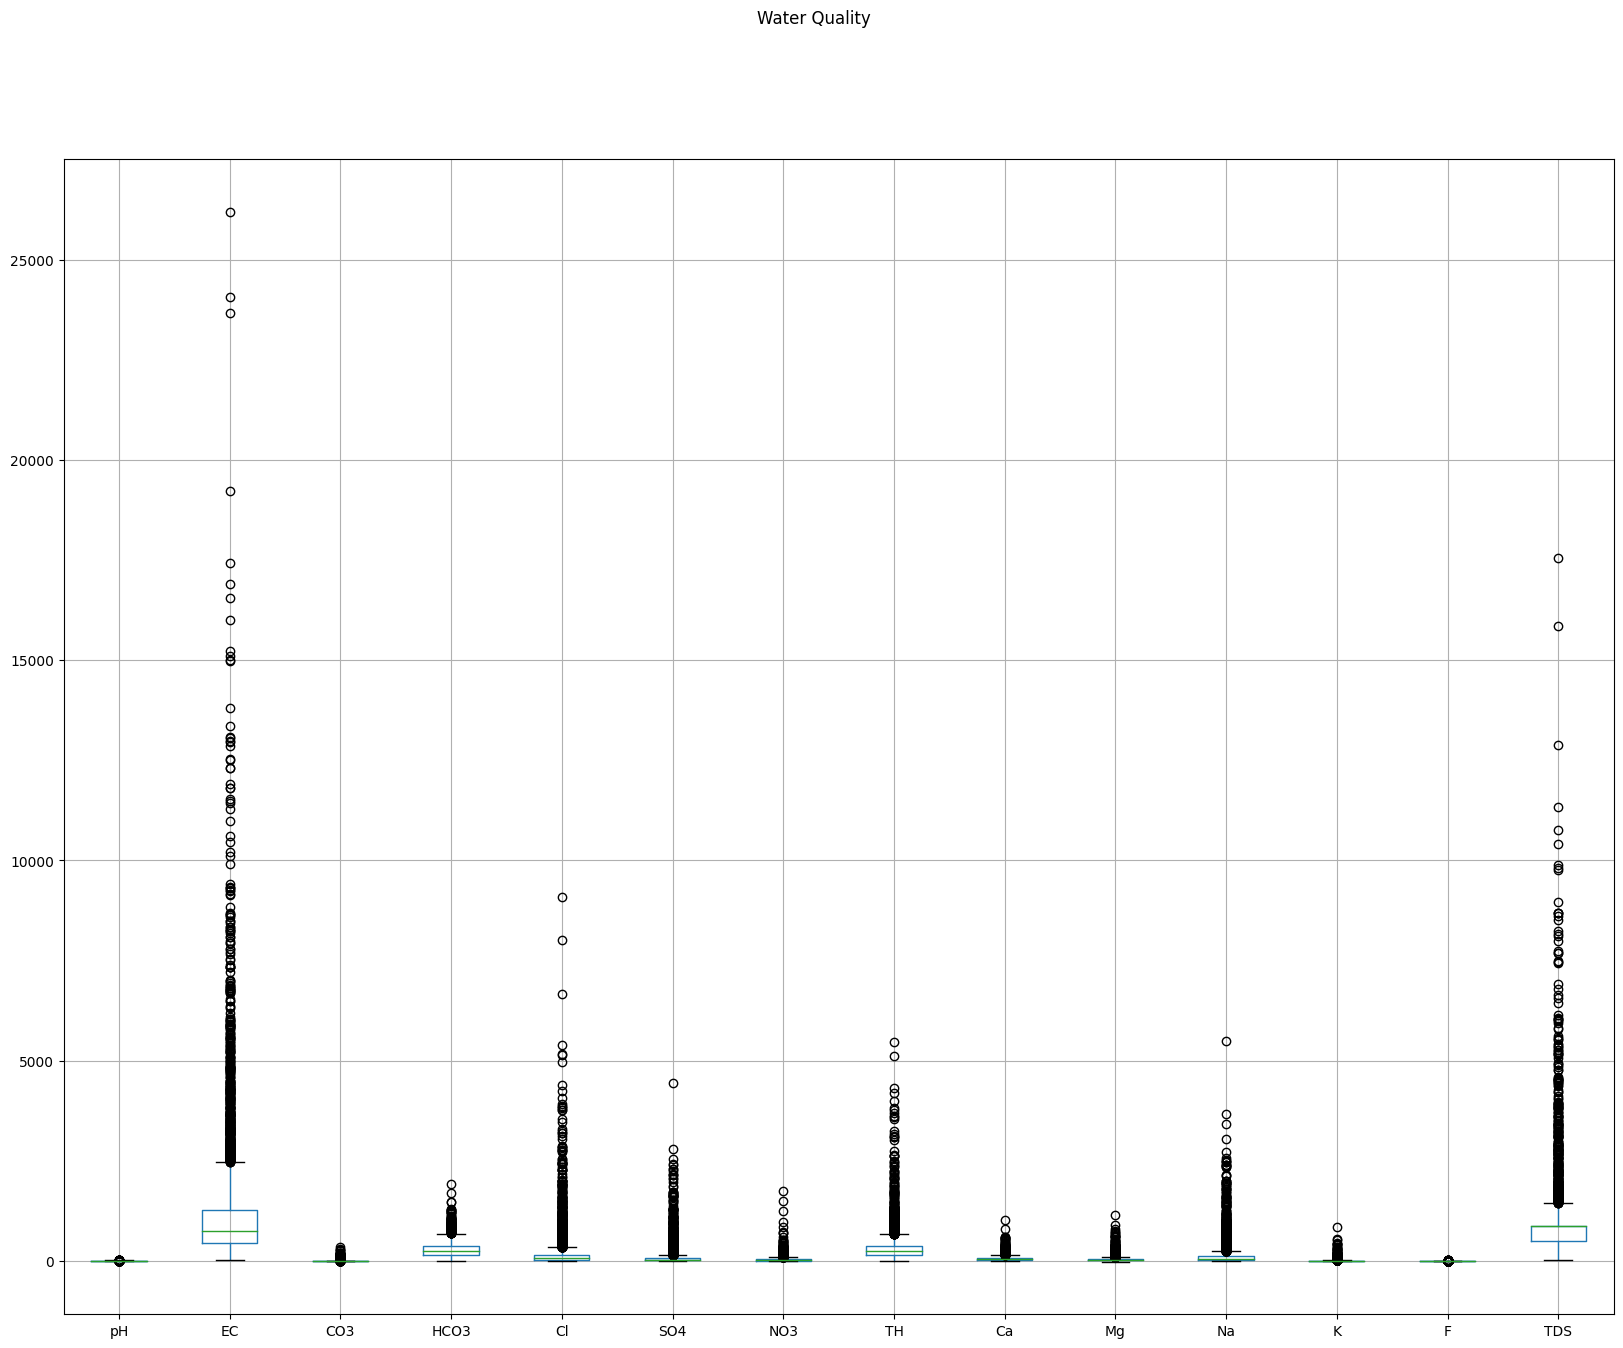

In [ ]:
plt.figure(figsize=(20,15))
plt.suptitle("Water Quality")
ax = plt.gca()

Required_parameters.boxplot()
Required_parameters.shape

# IQR For outlier Handling




<Axes: >

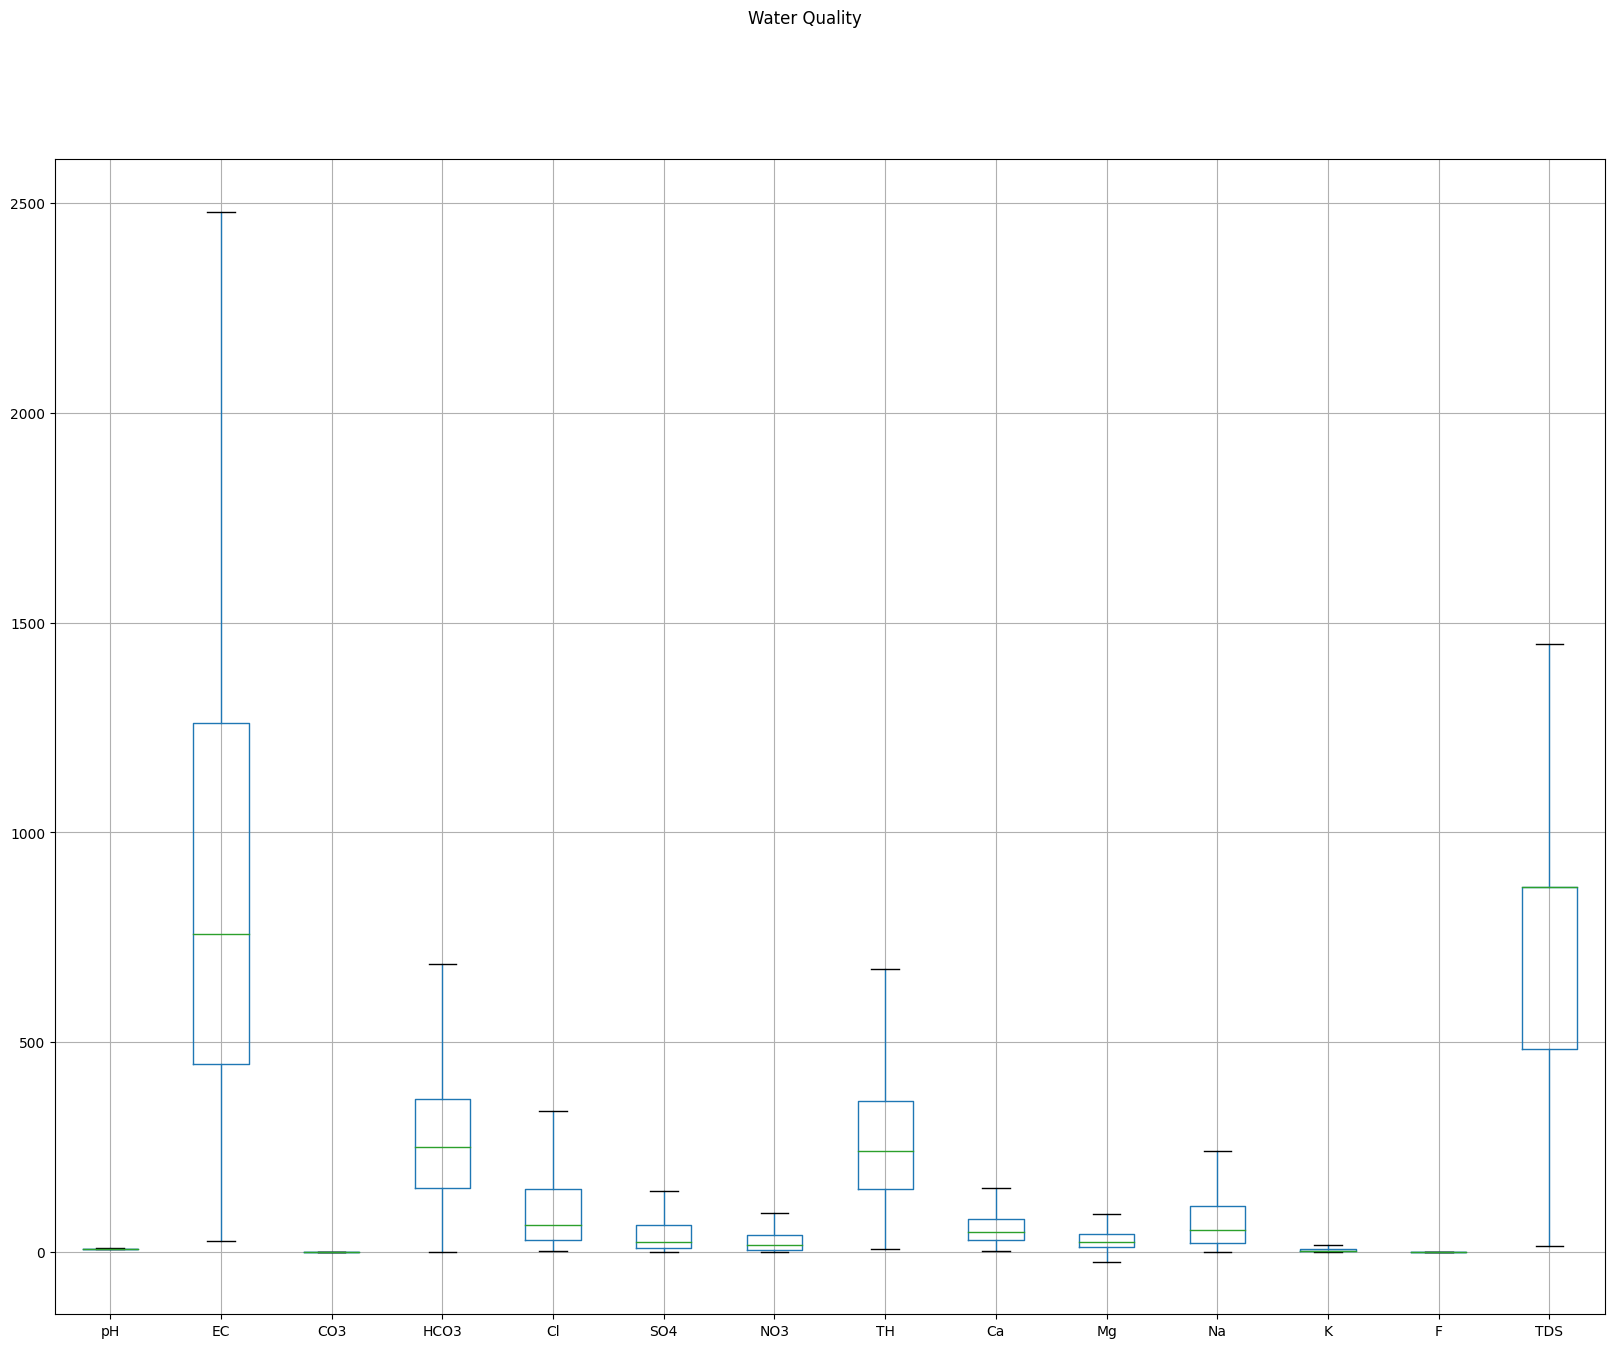

In [ ]:
data_cap = Required_parameters.copy()

def iqr_capping(data, cols, factor):

    for col in cols:

        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)

        iqr = q3 - q1

        upper_whisker = q3 + (factor*iqr)
        lower_whisker = q1 - (factor*iqr)

        data[col] = np.where(data[col]>upper_whisker, upper_whisker,
                 np.where(data[col]<lower_whisker, lower_whisker, data[col]))

iqr_capping(data_cap, Required_parameters, 1.5)
data_cap.shape

plt.figure(figsize=(20,15))
plt.suptitle("Water Quality")
ax = plt.gca()
data_cap.boxplot()

# Data Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_range = 0
max_range = 1

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(min_range, max_range))

# Normalize the DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(data_cap), columns=data_cap.columns)

normalized_data

,pH,EC,CO3,HCO3,Cl,SO4,NO3,TH,Ca,Mg,Na,K,F,TDS
0,0.475877,0.131285,0.0,0.266958,0.069524,0.006849,0.010734,0.252169,0.212963,0.396476,0.041456,0.000000,0.567568,0.132839
1,0.383772,0.258141,0.0,0.382203,0.240336,0.034247,0.010734,0.364343,0.332011,0.458150,0.211425,0.060790,0.189189,0.254864
2,0.370614,0.099061,0.0,0.169220,0.099491,0.006849,0.000000,0.177386,0.014550,0.449339,0.041456,0.060790,0.310811,0.094489
3,0.414474,0.115785,0.0,0.231947,0.111477,0.013699,0.000000,0.192342,0.160053,0.352423,0.062184,0.121581,0.250000,0.127261
4,0.510965,1.000000,0.0,0.746900,1.000000,0.383562,0.053670,0.685911,0.358466,0.898678,1.000000,1.000000,0.641892,0.982130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5370,0.427632,0.110605,0.0,0.035624,0.207072,0.000000,0.026191,0.080168,0.054299,0.277445,0.095349,0.232827,0.141892,0.097138
5371,0.405702,0.024604,0.0,0.053435,0.026476,0.063904,0.009446,0.050254,0.041071,0.245374,0.028149,0.215805,0.182432,0.020479
5372,0.366228,0.058272,0.0,0.097958,0.037099,0.209247,0.017282,0.102602,0.080754,0.288106,0.075243,0.148936,0.243243,0.050637
5373,0.357456,0.101101,0.0,0.124683,0.143332,0.106164,0.014491,0.214777,0.120503,0.416388,0.025454,0.518541,0.304054,0.090863


#Main data


Data Spliting

In [ ]:
# Splitting the dataset into features (X) and target (y)
X_main = normalized_data
y_main = df['Potability']
# pH	EC	CO3	HCO3	Cl	SO4	NO3	TH	Ca	Mg	Na	K	F	TDS

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X_main, y_main, test_size=0.2, random_state=0)

Standardization

#Model Implementation

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression Classifier
lg_classifier = LogisticRegression()

# Training the Logistic Regression model with the training data
lg_classifier.fit(X_train_main, y_train_main)

# Accuracy score on training data
X_train_pred = lg_classifier.predict(X_train_main)
training_data_accuracy = accuracy_score(y_train_main, X_train_pred)

# Accuracy score on test data
X_test_pred = lg_classifier.predict(X_test_main)
test_data_accuracy = accuracy_score(y_test_main, X_test_pred)

# Calculating the accuracy score
logistic_regression_accuracy = accuracy_score(y_test_main, X_test_pred)

# Perform cross-validation
cv_scores = cross_val_score(lg_classifier, X_train_main, y_train_main, cv=5)

print('Accuracy score of training data while using Logistic Regression: ', training_data_accuracy)
print('Accuracy score of testing data while using Logistic Regression: ', test_data_accuracy)
#print("Accuracy Score:", logistic_regression_accuracy)
print("Mean Cross-Validation Score:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy score of training data while using Logistic Regression:  0.9306976744186046
Accuracy score of testing data while using Logistic Regression:  0.9395348837209302
Mean Cross-Validation Score: 0.9197674418604651


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize Random Forest and CA
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed

# Training the Random Forest model with the training data
rf_model.fit(X_train_main, y_train_main)

# Accuracy score on training data
rf_X_train_pred = rf_model.predict(X_train_main)
rf_training_data_accuracy = accuracy_score(y_train_main, rf_X_train_pred)

# Accuracy score on test data
rf_X_test_pred = rf_model.predict(X_test_main)
rf_test_data_accuracy = accuracy_score(y_test_main, rf_X_test_pred)

# Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
rf_cv_scores = cross_val_score(rf_model, X_test_main,y_test_main, cv=5, scoring='accuracy')
rf_cv_scores = np.mean(rf_cv_scores)

print('Accuracy score of training data while using Random Forest:', rf_training_data_accuracy)
print('Accuracy score of testing data while using Random Forest:', rf_test_data_accuracy)
print("Mean CV Score on testing data:", rf_cv_scores)

Accuracy score of training data while using Random Forest: 1.0
Accuracy score of testing data while using Random Forest: 0.9106976744186046
Mean CV Score on testing data: 0.881860465116279


SVM

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import SVC

# Create an SVM model
svm_model = SVC(kernel='linear', random_state=42) # You can choose a different kernel if needed

# Train the SVM model on the training data
svm_model.fit(X_train_main, y_train_main)

# Predict labels on the training and testing data
svm_train_pred = svm_model.predict(X_train_main)
svm_test_pred = svm_model.predict(X_test_main)

# Calculate training and testing accuracy
svm_train_accuracy = accuracy_score(y_train_main, svm_train_pred)
svm_test_accuracy = accuracy_score(y_test_main, svm_test_pred)

# Perform cross-validation
cv_scores = cross_val_score(svm_model, X_train_main, y_train_main, cv=5)

# Print the results
print("Training Accuracy:", svm_train_accuracy)
print("Testing Accuracy:", svm_test_accuracy)
#print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Training Accuracy: 0.9595348837209302
Testing Accuracy: 0.9609302325581396
Mean Cross-Validation Score: 0.9527906976744186


Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create an Dscision tree classifier
DecTree_classifier = DecisionTreeClassifier()

#training the knn model with the training data
DecTree_classifier.fit(X_train_main, y_train_main)

# Predict labels on the training and testing data
X_train_pred = DecTree_classifier.predict(X_train_main)
X_test_pred = DecTree_classifier.predict(X_test_main)

# Calculate training and testing accuracy
training_data_accuracy= accuracy_score(y_train_main , X_train_pred)
test_data_accuracy=accuracy_score(y_test_main , X_test_pred)

# Perform cross-validation
cv_scores = cross_val_score(DecTree_classifier, X_train_main, y_train_main, cv=5)

print('Accuracy score of training data while knn: ' , training_data_accuracy)
print('Accuracy score of testing data while knn: ' , test_data_accuracy)
#print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Accuracy score of training data while knn:  1.0
Accuracy score of testing data while knn:  0.8558139534883721
Mean Cross-Validation Score: 0.8730232558139536


XGB

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize XGBoost and RFE
xgb_model = XGBClassifier(n_estimators=100, random_state=42)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_train_main = label_encoder.fit_transform(y_train_main)

# Training the Logistic Regression model with the training data
xgb_model.fit(X_train_main, y_train_main)

# Accuracy score on training data
xgb_X_train_pred = xgb_model.predict(X_train_main)
xgb_training_data_accuracy = accuracy_score(y_train_main, xgb_X_train_pred)

# to convert y_train from string to Integer--------------
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Convert target variable to integers
y_test_main = label_encoder.fit_transform(y_test_main)

# Accuracy score on test data
xgb_X_test_pred = xgb_model.predict(X_test_main)
xgb_test_data_accuracy = accuracy_score(y_test_main, xgb_X_test_pred)

# :Cross Validation on test dataset using selected features array
# Perform cross-validation on testing dataset
xgb_cv_scores = cross_val_score(xgb_model, X_test_main, y_test_main, cv=5, scoring='accuracy')
xgb_cv_scores=np.mean(xgb_cv_scores)


print('Accuracy score of training data while using Logistic Regression: ', xgb_training_data_accuracy)
print('Accuracy score of testing data while using Logistic Regression: ', xgb_test_data_accuracy)
print("Mean CV Score on testing data:", np.mean(xgb_cv_scores))


Accuracy score of training data while using Logistic Regression:  1.0
Accuracy score of testing data while using Logistic Regression:  0.9293023255813954
Mean CV Score on testing data: 0.8846511627906976


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create an KNN classifier
knn_classifier=KNeighborsClassifier(n_neighbors=5)

#training the knn model with the training data
knn_classifier.fit(X_train_main , y_train_main)

# Predict labels on the training and testing data
X_train_pred = knn_classifier.predict(X_train_main)
X_test_pred = knn_classifier.predict(X_test_main)

# Calculate training and testing accuracy
training_data_accuracy= accuracy_score(y_train_main , X_train_pred)
test_data_accuracy=accuracy_score(y_test_main, X_test_pred)

# Perform cross-validation
cv_scores = cross_val_score(knn_classifier, X_train_main, y_train_main, cv=5)

print('Accuracy score of training data while knn: ' , training_data_accuracy)
print('Accuracy score of testing data while knn: ' , test_data_accuracy)
#print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Accuracy score of training data while knn:  0.9113953488372093
Accuracy score of testing data while knn:  0.8493023255813954
Mean Cross-Validation Score: 0.8555813953488371


Gradient Boost Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()

# Training the Gradient Boosting model with the training data
gb_classifier.fit(X_train_main, y_train_main)

# Accuracy score on training data
X_train_pred = gb_classifier.predict(X_train_main)
training_data_accuracy = accuracy_score(y_train_main, X_train_pred)

# Accuracy score on test data
X_test_pred = gb_classifier.predict(X_test_main)
test_data_accuracy = accuracy_score(y_test_main, X_test_pred)

# Calculating the accuracy score
gradient_boost_accuracy = accuracy_score(y_test_main, X_test_pred)

# Perform cross-validation
cv_scores = cross_val_score(gb_classifier, X_train_main, y_train_main, cv=5)

print('Accuracy score of training data while using Gradient Boosting: ', training_data_accuracy)
print('Accuracy score of testing data while using Gradient Boosting: ', test_data_accuracy)
print("Accuracy Score:", gradient_boost_accuracy)
print("Mean Cross-Validation Score:", cv_scores.mean())

Accuracy score of training data while using Gradient Boosting:  0.9934883720930232
Accuracy score of testing data while using Gradient Boosting:  0.9190697674418604
Accuracy Score: 0.9190697674418604
Mean Cross-Validation Score: 0.9223255813953488


MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Create an MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(3,2), max_iter=500, activation='relu')

# Train the MLP model on the training data
mlp_model.fit(X_train_main,y_train_main)

# Predict labels on the training and testing data
mlp_train_pred = mlp_model.predict(X_train_main)
mlp_test_pred = mlp_model.predict(X_test_main)

# Calculate training and testing accuracy
mlp_train_accuracy = accuracy_score(y_train_main, mlp_train_pred)
mlp_test_accuracy = accuracy_score(y_test_main, mlp_test_pred)

# Calculating the accuracy score
mlp_accuracy = accuracy_score(y_test_main, mlp_test_pred)

# Perform cross-validation
cv_scores = cross_val_score(mlp_model, X_train_main, y_train_main, cv=5)

# Print the results
print("Training Accuracy:", mlp_train_accuracy)
print("Testing Accuracy:", mlp_test_accuracy)
#print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.30930232558139537
Testing Accuracy: 0.3032558139534884
Mean Cross-Validation Score: 0.7951162790697673


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
